In [25]:
import json

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from itertools import product

In [26]:
# Load data
with open("data/tmdb_movies.json", "r", encoding="utf-8") as f:
    movies = json.load(f)

with open("data/recommended_movie_data.json", "r", encoding="utf-8") as f:
    recommended_data = json.load(f)

# Build lookups
recommended_lookup = {movie["id"]: movie for movie in recommended_data}
movie_dict = {movie["id"]: movie for movie in movies}

# Merge recommended movies into a unified list (if not already present)
all_movies = {**movie_dict, **recommended_lookup}

In [27]:
def countries_parser(movie):
    origin_country = movie.get("origin_country", [])

    production_countries = movie.get("production_countries", [])
    production_countries = [country.get("iso_3166_1") for country in production_countries if isinstance(country, dict) and "iso_3166_1" in country]
    
    production_companies = movie.get("production_companies", [])
    production_companies = [company.get("origin_country") for company in production_companies if isinstance(company, dict) and "origin_country" in company]

    all_movie_countries = set()
    all_movie_countries.update([c.lower() for c in origin_country if isinstance(c, str)])
    all_movie_countries.update([c.lower() for c in production_countries if isinstance(c, str)])
    all_movie_countries.update([c.lower() for c in production_companies if isinstance(c, str)])

    return all_movie_countries


def get_all_countries(all_movies):
    all_countries = dict()
    brazilians = set()
    for _, movie in all_movies.items():
        all_movie_countries = countries_parser(movie)

        for c in all_movie_countries:
            country_name = c.lower() if isinstance(c, str) else ""
            if country_name:
                all_countries[country_name] = all_countries.get(country_name, 0) + 1
                
                if country_name == "br":
                    brazilians.add(movie.get("title", ""))

    return all_countries, brazilians

In [28]:
all_countries, all_countries_brazilians = get_all_countries(all_movies)
all_countries_top_250, all_countries_top_250_brazilians = get_all_countries(movie_dict)

all_countries = dict(sorted(all_countries.items(), key=lambda item: item[1], reverse=True))
all_countries_top_250 = dict(sorted(all_countries_top_250.items(), key=lambda item: item[1], reverse=True))

print("Total countries in all movies:", len(all_countries), len(all_movies))
print("Total countries in top 250 movies:", len(all_countries_top_250))

Total countries in all movies: 86 2573
Total countries in top 250 movies: 29


In [29]:
print(all_countries)
print(sum(all_countries.values()))

{'us': 1766, 'gb': 361, 'fr': 274, 'jp': 151, 'de': 147, 'it': 135, 'in': 109, 'ca': 82, 'es': 70, 'kr': 44, 'cn': 41, 'se': 40, 'be': 40, 'tr': 39, 'br': 35, 'au': 33, 'hk': 30, 'mx': 25, 'dk': 24, 'ie': 21, 'ar': 18, 'nl': 18, 'su': 17, 'nz': 15, 'ch': 15, 'pl': 13, 'ir': 12, 'no': 11, 'cz': 11, 'ru': 10, 'tw': 9, 'lb': 8, 'at': 7, 'za': 6, 'fi': 6, 'bg': 6, 'xc': 5, 'hu': 5, 'cl': 5, 'ma': 4, 'lu': 4, 'ro': 4, 'gr': 4, 'qa': 4, 'eg': 4, 'dz': 3, 'il': 3, 'pt': 3, 'yu': 3, 'ph': 3, 'sn': 3, 'sa': 3, 'ae': 3, 'li': 2, 'xg': 2, 'rs': 2, 'ly': 2, 'kw': 2, 'th': 2, 'do': 2, 'ee': 2, 'pa': 1, 'lt': 1, 'is': 1, 'pe': 1, 'gh': 1, 'cs': 1, 'zw': 1, 'ua': 1, 'mk': 1, 'tn': 1, 'hr': 1, 'ba': 1, 'sg': 1, 'id': 1, 'om': 1, 'me': 1, 'sk': 1, 'sy': 1, 'mt': 1, 'mw': 1, 'ps': 1, 'ge': 1, 'mz': 1, 'lv': 1, 'io': 1}
3753


In [30]:
print(all_countries_top_250)
print(sum(all_countries_top_250.values()))

{'us': 185, 'gb': 43, 'fr': 18, 'de': 15, 'jp': 15, 'it': 11, 'in': 8, 'es': 7, 'kr': 4, 'ca': 4, 'nz': 3, 'se': 3, 'au': 3, 'br': 2, 'hk': 2, 'tr': 2, 'ir': 2, 'at': 2, 'mx': 2, 'ar': 2, 'ie': 2, 'pl': 1, 'lb': 1, 'su': 1, 'dk': 1, 'ch': 1, 'cn': 1, 'za': 1, 'dz': 1}
343


In [31]:
print(all_countries_top_250_brazilians)

{'City of God', "I'm Still Here"}


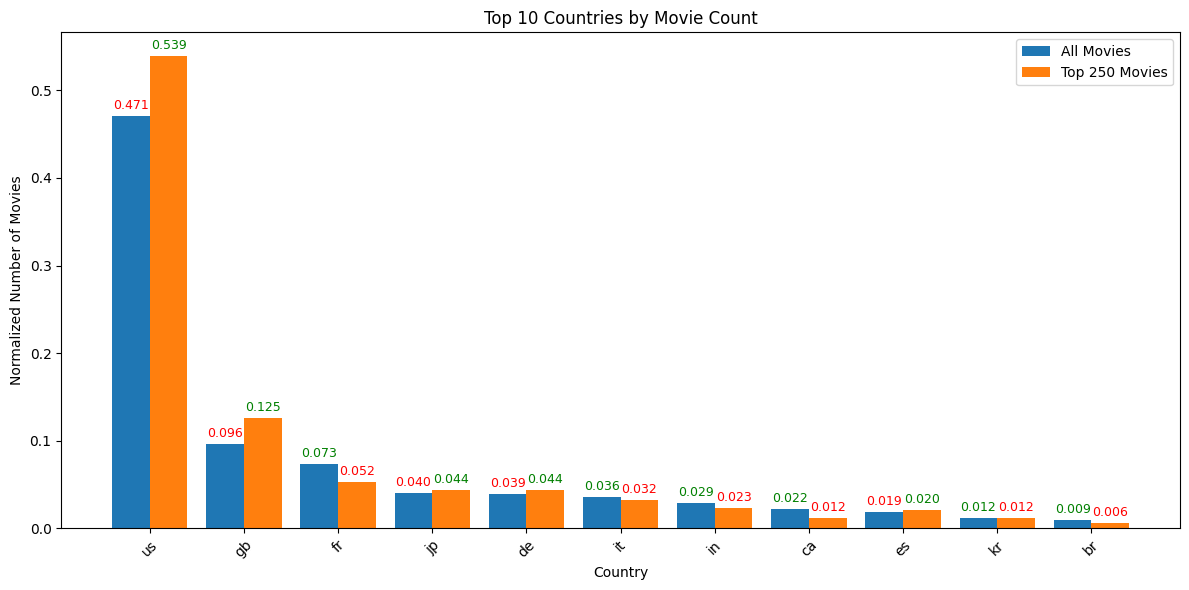

In [32]:
# Normalize using all data
total_all_counts = np.sum(list(all_countries.values()))
total_top_250_counts = np.sum(list(all_countries_top_250.values()))

# Get top 10 countries by total number of movies
# Get top 10 countries by total number of movies, plus 'br' if not already included
top_10 = sorted(all_countries.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_countries = [c[0] for c in top_10]

if 'br' not in top_10_countries and 'br' in all_countries:
    top_10_countries.append('br')

all_counts_norm = [all_countries[c] / total_all_counts for c in top_10_countries]
top_250_counts_norm = [all_countries_top_250.get(c, 0) / total_top_250_counts for c in top_10_countries]

x = np.arange(len(top_10_countries))
width = 0.4

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, all_counts_norm, width, label='All Movies')
bars2 = plt.bar(x + width/2, top_250_counts_norm, width, label='Top 250 Movies')
plt.xlabel('Country')
plt.ylabel('Normalized Number of Movies')
plt.title('Top 10 Countries by Movie Count')
plt.xticks(x, top_10_countries, rotation=45)
plt.legend()
plt.tight_layout()

# Annotate bars with their values
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    h1 = bar1.get_height()
    h2 = bar2.get_height()
    # Determine which bar is higher
    if h1 > h2:
        color1, color2 = 'green', 'red'
    elif h2 > h1:
        color1, color2 = 'red', 'green'
    else:
        color1 = color2 = 'black'
    plt.annotate(f'{h1:.3f}',
                 xy=(bar1.get_x() + bar1.get_width() / 2, h1),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color=color1)
    plt.annotate(f'{h2:.3f}',
                 xy=(bar2.get_x() + bar2.get_width() / 2, h2),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color=color2)

plt.show()

In [10]:
def get_lat_long(city_name):
    geolocator = Nominatim(user_agent="geoapi")

    city_name = city_name.lower()

    if city_name == "macedonia":
        city_name = "macedonia europe"

    if city_name == "georgia":
        city_name = "georgia europe"

    if city_name == "yugoslavia":
        city_name = "montenegro"

    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        return None

In [11]:
G = nx.Graph()

for idx, (country, value) in enumerate(all_countries.items()):
    lat, long = get_lat_long(country)
    G.add_node(
        country,
        title=country,
        label=country,
        type="country",
        value=value,
        lat=lat,
        long=long,
        index=idx
    )

In [12]:
for movie1 in all_movies.values():
    countries1 = countries_parser(movie1)

    for rec in movie1.get("recommendations", {}).get("results", []):
        id2 = rec.get("id")
        if id2 not in all_movies:
            continue

        movie2 = all_movies[id2]
        countries2 = countries_parser(movie2)

        for c1, c2 in product(countries1, countries2):
            if c1 != c2:
                if G.has_edge(c1, c2):
                    G[c1][c2]["weight"] += 1
                else:
                    G.add_edge(c1, c2, weight=1)

In [13]:
nx.write_gexf(G, "networks/countries.gexf")